In [1]:
import multiprocessing
import random
import pandas as pd
import numpy as np
import shap
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from openpyxl import Workbook

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#Check versions of library
import sklearn
import matplotlib
print("panda:"+pd.__version__)
print("sklern:"+sklearn.__version__)
print("numpy:"+np.__version__)
print("matplotlib"+matplotlib.__version__)

panda:1.4.2
sklern:1.1.1
numpy:1.20.3
matplotlib3.4.3


# Functions

In [ ]:
def traindata(X, y_train):
    model =RandomForestClassifier()
    model.fit(X_train,y_train)
    return model


def removeFromListByIndex(obj_list,index_list):
    return [x for i,x in enumerate(obj_list) if i not in index_list]



# Load Data
SNP data was generated using mutation_detector (https://github.com/smha118/mutation_detector)

In [5]:
aa_dna2int={"N/A":0,"G":1,"A":2,"S":3,"P":4,"V":5,"T":6,"C":7,
           "I":8,"L":9,"N":10,"D":11,"Q":12,"K":13,"E":14,"M":15,
           "H":16,"F":17,"R":18,"Y":19,"W":20,"-":-1,"a":21,"t":22,"c":23,"g":24,"partial":0}

i=0
snp_data=np.empty((0,97),int)
positions=np.array([])
ceftriaxone=np.array([])
cefixime=np.array([])
with open("data/Ceftriaxone_NG_SNPs.txt","r") as f:
    all_lines = f.readlines()
    for line in all_lines:
        tabs=line.replace("\n","").split("\t")
        if i ==0:
            positions=np.append(positions,tabs[3:])
        else:
            row=np.array([])
            if tabs[2] == "S":
                ceftriaxone=np.append(ceftriaxone,0)
            else:    
                ceftriaxone=np.append(ceftriaxone,1)
            if tabs[1] == "S":
                cefixime=np.append(cefixime,0)
            else:
                cefixime=np.append(cefixime,1)

            for j in range(3,len(tabs)):
                if j == (len(tabs)-1):
                    key=tabs[j].lower()
                    row=np.append(row,aa_dna2int[key])
                else:
                    key=tabs[j]
                    row=np.append(row,aa_dna2int[key])
            snp_data=np.append(snp_data, [row],axis=0)
        i=i+1
ceftriaxone = pd.Series(ceftriaxone)
snp_data = pd.DataFrame(snp_data, columns = positions)

# SMOTE
Since our data is imbalanced between susceptible vs non-susceptible N.gonorrhoeae genomes, we used SMOTE to balance out the data

In [6]:
#SMOTE
smote = SMOTE(sampling_strategy="minority")
X_sm, y_sm = smote.fit_resample(snp_data, ceftriaxone)

Split the data into train and test set in 7:3 ratio

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3)

# 10 fold cross-validation


In [95]:

classifiers = [LogisticRegression(max_iter=10000), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0),
               svm.SVC(probability=True)
              ]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers','precision','recall', 'auc','acc','bal_acc','f1_score'])
result_table_mean = pd.DataFrame(columns=['classifiers','precision','recall', 'auc','acc','bal_acc','f1_score'])

# Train the models and record the results
scoring = {'acc': 'accuracy',
           'bal_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
          'f1':'f1',
          'precision':'precision',
          'recall':'recall'}
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    scores = cross_validate(cls, X_train, y_train, cv=10,scoring=scoring)
    yproba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'precision':scores['test_precision'],
                                        'recall':scores['test_recall'],
                                        'auc':scores['test_auc'],
                                        'acc':scores['test_acc'],
                                        'bal_acc':scores['test_bal_acc'],
                                        'f1_score':scores['test_f1'],
                                        'fpr':fpr,
                                        'tpr':tpr
                                         }, ignore_index=True)
    result_table_mean= result_table_mean.append({'classifiers':cls.__class__.__name__,
                                        'precision':statistics.mean(scores['test_precision']),
                                        'recall':statistics.mean(scores['test_recall']),
                                        'auc':statistics.mean(scores['test_auc']),
                                        'acc':statistics.mean(scores['test_acc']),
                                        'bal_acc':statistics.mean(scores['test_bal_acc']),
                                        'f1_score':statistics.mean(scores['test_f1']),
                                        'fpr':fpr,
                                        'tpr':tpr         
                                         }, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
result_table_mean.set_index('classifiers',inplace=True)
result_table_models= result_table
result_table_mean_models=result_table_mean

In [98]:
result_table_models

,precision,recall,auc,acc,bal_acc,f1_score,fpr,tpr
classifiers,,,,,,,,
LogisticRegression,"[0.8936170212765957, 0.8870229007633588, 0.875...","[0.92018779342723, 0.9092331768388107, 0.90297...","[0.9521430044522086, 0.9341182322184616, 0.937...","[0.9057632398753894, 0.897196261682243, 0.8878...","[0.9058303308221421, 0.897252247334134, 0.8879...","[0.9067077872012336, 0.8979907264296755, 0.889...","[0.0, 0.0, 0.0, 0.0, 0.00036656891495601173, 0...","[0.0, 0.006844380403458214, 0.0162103746397694..."
GaussianNB,"[0.7167235494880546, 0.7147766323024055, 0.732...","[0.9859154929577465, 0.9765258215962441, 0.964...","[0.8899794980043915, 0.8904222925841007, 0.875...","[0.7990654205607477, 0.794392523364486, 0.8068...","[0.7999344906649197, 0.7952396549841686, 0.807...","[0.8300395256916996, 0.8253968253968255, 0.832...","[0.0, 0.14736070381231672, 0.16715542521994134...","[0.0, 0.8202449567723343, 0.8735590778097982, ..."
KNeighborsClassifier,"[0.9057187017001546, 0.8827893175074184, 0.887...","[0.917057902973396, 0.9311424100156495, 0.9405...","[0.9417185282236051, 0.9460639807839284, 0.934...","[0.9112149532710281, 0.9042056074766355, 0.911...","[0.9112421297812716, 0.9043308949303053, 0.911...","[0.911353032659409, 0.9063214013709063, 0.9133...","[0.0, 0.008064516129032258, 0.0861436950146627...","[0.0, 0.3994956772334294, 0.8843659942363112, ..."
DecisionTreeClassifier,"[0.9027982326951399, 0.9011799410029498, 0.898...","[0.9593114241001565, 0.9561815336463224, 0.953...","[0.9684608945663645, 0.9559983501352646, 0.963...","[0.9283489096573209, 0.92601246105919, 0.92289...","[0.9284929213524038, 0.9261527823270372, 0.923...","[0.9301972685887708, 0.9278663629460895, 0.924...","[0.0, 0.002565982404692082, 0.0029325513196480...","[0.0, 0.26621037463976943, 0.29178674351585016..."
RandomForestClassifier,"[0.8986784140969163, 0.9011799410029498, 0.891...","[0.9577464788732394, 0.9561815336463224, 0.948...","[0.9668073904235057, 0.9604129514381725, 0.963...","[0.9252336448598131, 0.92601246105919, 0.91666...","[0.9253848673435965, 0.9261527823270372, 0.916...","[0.9272727272727272, 0.9278663629460895, 0.918...","[0.0, 0.001466275659824047, 0.0014662756598240...","[0.0, 0.20605187319884727, 0.20677233429394812..."
GradientBoostingClassifier,"[0.8414376321353065, 0.8494623655913979, 0.829...","[0.622848200312989, 0.6181533646322379, 0.5931...","[0.8863595006732904, 0.8886680981669518, 0.861...","[0.7538940809968847, 0.7554517133956387, 0.736...","[0.7532845652727735, 0.7548131164246461, 0.736...","[0.7158273381294965, 0.7155797101449276, 0.691...","[0.0, 0.006964809384164223, 0.0069648093841642...","[0.0, 0.10842939481268012, 0.11095100864553314..."
SVC,"[0.8529411764705882, 0.842998585572843, 0.8412...","[0.9530516431924883, 0.9327073552425665, 0.937...","[0.9379347575548035, 0.9292948041392195, 0.924...","[0.8948598130841121, 0.8800623052959502, 0.880...","[0.8951304727590348, 0.8803071659933763, 0.881...","[0.9002217294900222, 0.885586924219911, 0.8867...","[0.0, 0.00036656891495601173, 0.00036656891495...","[0.0, 0.001440922190201729, 0.0039625360230547..."


In [97]:
result_table_mean_models

,precision,recall,auc,acc,bal_acc,f1_score,fpr,tpr
classifiers,,,,,,,,
LogisticRegression,0.887317,0.916974,0.945139,0.900467,0.900526,0.901777,"[0.0, 0.0, 0.0, 0.0, 0.00036656891495601173, 0...","[0.0, 0.006844380403458214, 0.0162103746397694..."
GaussianNB,0.723291,0.975922,0.886714,0.801246,0.801896,0.830587,"[0.0, 0.14736070381231672, 0.16715542521994134...","[0.0, 0.8202449567723343, 0.8735590778097982, ..."
KNeighborsClassifier,0.884098,0.950897,0.947449,0.913006,0.913138,0.915965,"[0.0, 0.008064516129032258, 0.0861436950146627...","[0.0, 0.3994956772334294, 0.8843659942363112, ..."
DecisionTreeClassifier,0.902933,0.953722,0.962279,0.925779,0.925884,0.927576,"[0.0, 0.002565982404692082, 0.0029325513196480...","[0.0, 0.26621037463976943, 0.29178674351585016..."
RandomForestClassifier,0.903394,0.954190,0.965840,0.926246,0.926352,0.928034,"[0.0, 0.001466275659824047, 0.0014662756598240...","[0.0, 0.20605187319884727, 0.20677233429394812..."
GradientBoostingClassifier,0.856833,0.611318,0.883721,0.755452,0.754918,0.713480,"[0.0, 0.006964809384164223, 0.0069648093841642...","[0.0, 0.10842939481268012, 0.11095100864553314..."
SVC,0.858429,0.936363,0.936335,0.891121,0.891289,0.895522,"[0.0, 0.00036656891495601173, 0.00036656891495...","[0.0, 0.001440922190201729, 0.0039625360230547..."


len(X_train)

# ROC curve

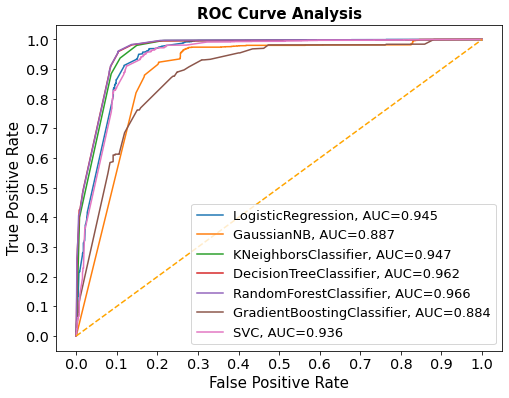

In [99]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table_mean.loc[i]['fpr'], 
             result_table_mean.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table_mean.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')


plt.show()

# Shap value calculation on randomforest model
Shap value was used as a contribution score for individual mutation

In [31]:
data = pd.read_csv("/home/smha118/data1/gonnorhea/train.csv")
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])

In [16]:
# Dropping Features
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

train = train.drop(['PassengerId'], axis=1)
test = test.drop(['PassengerId'], axis=1)

# Convert categorical variables into dummy/indicator variables
train_processed = pd.get_dummies(train)
test_processed = pd.get_dummies(test)

# Filling Null Values
train_processed = train_processed.fillna(train_processed.mean())
test_processed = test_processed.fillna(test_processed.mean())

# Create X_train,Y_train,X_test
X_train = train_processed.drop(['Survived'], axis=1)
Y_train = train_processed['Survived']

X_test  = test_processed.drop(['Survived'], axis=1)
Y_test  = test_processed['Survived']

# Display
print("Processed DataFrame for Training : Survived is the Target, other columns are features.")
display(train_processed.head())

Processed DataFrame for Training : Survived is the Target, other columns are features.


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
231,0,3,29.000000,0,0,7.7750,0,1,0,0,1
836,0,3,21.000000,0,0,8.6625,0,1,0,0,1
639,0,3,29.526048,1,0,16.1000,0,1,0,0,1
389,1,2,17.000000,0,0,12.0000,1,0,1,0,0
597,0,3,49.000000,0,0,0.0000,0,1,0,0,1


In [12]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
random_forest_preds = random_forest.predict(X_test)
print('The accuracy of the Random Forests model is :\t',metrics.accuracy_score(random_forest_preds,y_test))

The accuracy of the Random Forests model is :	 0.9255087209302325


In [13]:
import shap 
shap_values = shap.TreeExplainer(random_forest).shap_values(X_train)

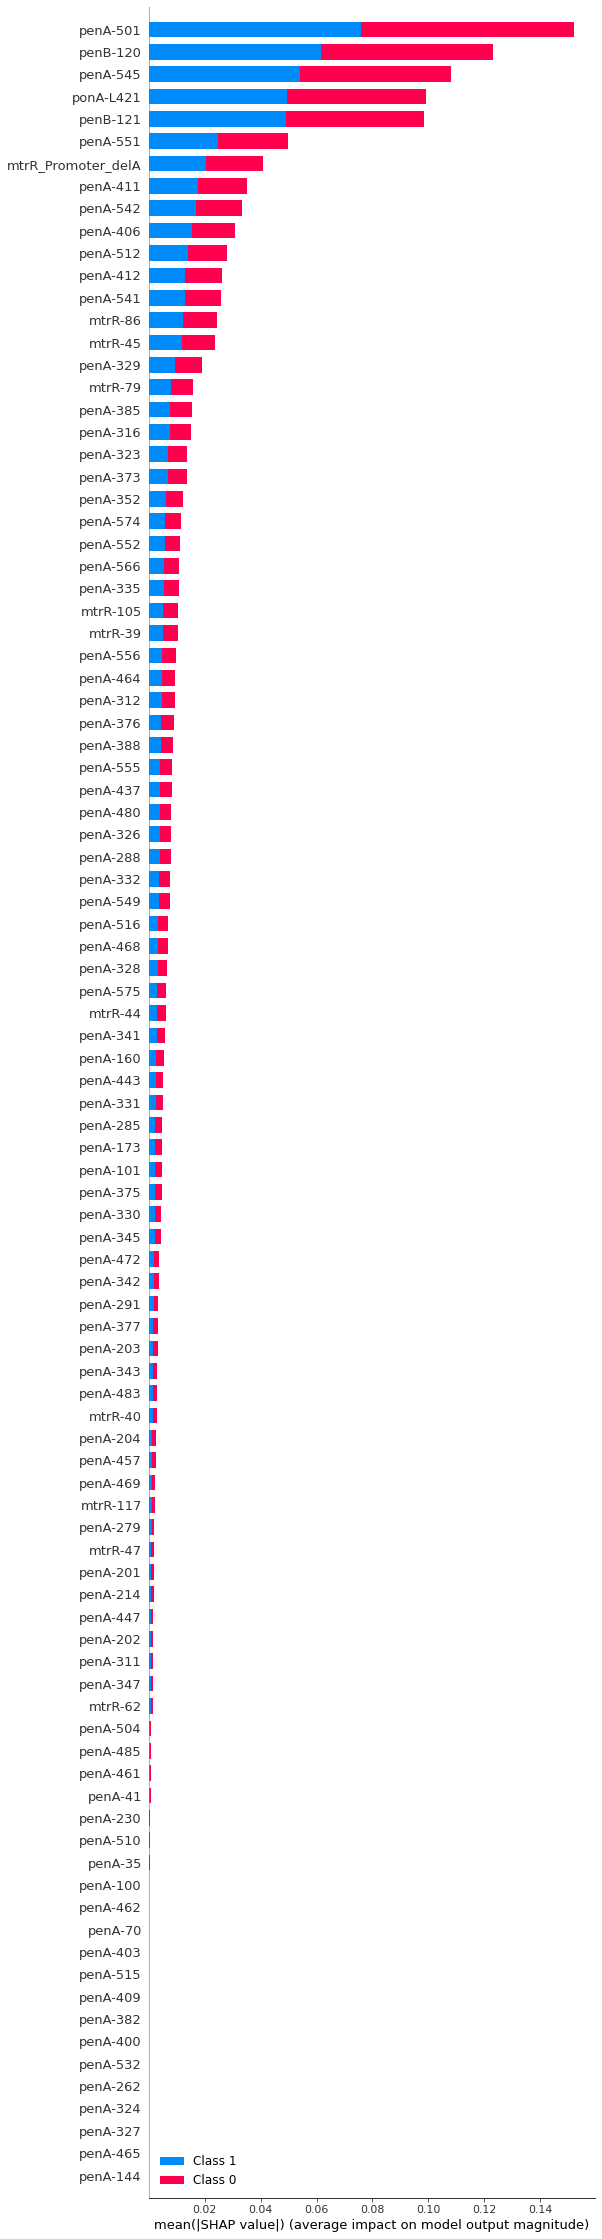

In [16]:
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=97)

# AUC curve for top genes from Shap results

In [101]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [119]:
result_table = pd.DataFrame(columns=result_table_mean_models.keys())
result_table_full = pd.DataFrame(columns=result_table_models.keys())

In [67]:
result_table.loc["All",]=result_table_mean_models.loc["RandomForestClassifier",]
result_table_full.loc["All",]=result_table_models.loc["RandomForestClassifier",]

In [120]:
result_table = result_table.append({'SNPs':"All",
                                    'fpr':result_table_mean_models.loc["RandomForestClassifier","fpr"], 
                                    'tpr':result_table_mean_models.loc["RandomForestClassifier","tpr"], 
                                    'precision':result_table_mean_models.loc["RandomForestClassifier","precision"],
                                    'recall':result_table_mean_models.loc["RandomForestClassifier","recall"],
                                    'auc':result_table_mean_models.loc["RandomForestClassifier","auc"],
                                    'acc':result_table_mean_models.loc["RandomForestClassifier","acc"],
                                    'bal_acc':result_table_mean_models.loc["RandomForestClassifier","bal_acc"],
                                    'f1_score':result_table_mean_models.loc["RandomForestClassifier","f1_score"],
                                   }, ignore_index=True)

result_table_full = result_table_full.append({'SNPs':"All",
                                    'fpr':result_table_models.loc["RandomForestClassifier","fpr"], 
                                    'tpr':result_table_models.loc["RandomForestClassifier","tpr"], 
                                    'precision':result_table_models.loc["RandomForestClassifier","precision"],
                                    'recall':result_table_models.loc["RandomForestClassifier","recall"],
                                    'auc':result_table_models.loc["RandomForestClassifier","auc"],
                                    'acc':result_table_models.loc["RandomForestClassifier","acc"],
                                    'bal_acc':result_table_models.loc["RandomForestClassifier","bal_acc"],
                                    'f1_score':result_table_models.loc["RandomForestClassifier","f1_score"],
                                   }, ignore_index=True)

# All 97 mutations

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3)
model = traindata(X_train, y_train)
yproba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  yproba)
# Train the models and record the results
scoring = {'acc': 'accuracy',
           'bal_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
          'f1':'f1',
          'precision':'precision',
          'recall':'recall'}
scores = cross_validate(LogisticRegression(max_iter=10000), X_train, y_train, cv=10,scoring=scoring)
result_table = result_table.append({'SNPs':"All",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':statistics.mean(scores['test_precision']),
                                    'recall':statistics.mean(scores['test_recall']),
                                    'auc':statistics.mean(scores['test_auc']),
                                    'acc':statistics.mean(scores['test_acc']),
                                    'bal_acc':statistics.mean(scores['test_bal_acc']),
                                    'f1_score':statistics.mean(scores['test_f1']),
                                   }, ignore_index=True)

result_table_full = result_table_full.append({'SNPs':"All",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':scores['test_precision'],
                                    'recall':scores['test_recall'],
                                    'auc':scores['test_auc'],
                                    'acc':scores['test_acc'],
                                    'bal_acc':scores['test_bal_acc'],
                                    'f1_score':scores['test_f1'],
                                   }, ignore_index=True)


# Top 20 mutations

In [122]:
to_add=[
    "penA-501","penB-120","ponA-L421","penB-121","penA-545","mtrR_Promoter_delA",
    "penA-551","penA-542","penA-406","penA-512","mtrR-86","penA-541","penA-328","mtrR-45",
    "penA-480","penA-411","penA-329","mtrR-79","penA-412","penA-335"
]



index_list=list()
for i in range(0,len(positions)):
    if positions[i] not in to_add:
        index_list.append(i)

        
positions_new=removeFromListByIndex(positions,index_list)
X_sm_rm=X_sm[positions_new]
X_train, X_test, y_train, y_test = train_test_split(X_sm_rm, y_sm, test_size=0.3)

model = traindata(X_train, y_train)
yproba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  yproba)
#auc = roc_auc_score(y_test, yproba)
#predict=model.predict(X_test)


scoring = {'acc': 'accuracy',
           'bal_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
          'f1':'f1',
          'precision':'precision',
          'recall':'recall'}
scores = cross_validate(LogisticRegression(max_iter=10000), X_train, y_train, cv=10,scoring=scoring)
result_table = result_table.append({'SNPs':"Top 20 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':statistics.mean(scores['test_precision']),
                                    'recall':statistics.mean(scores['test_recall']),
                                    'auc':statistics.mean(scores['test_auc']),
                                    'acc':statistics.mean(scores['test_acc']),
                                    'bal_acc':statistics.mean(scores['test_bal_acc']),
                                    'f1_score':statistics.mean(scores['test_f1']),
                                   }, ignore_index=True)

result_table_full = result_table_full.append({'SNPs':"Top 20 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':scores['test_precision'],
                                    'recall':scores['test_recall'],
                                    'auc':scores['test_auc'],
                                    'acc':scores['test_acc'],
                                    'bal_acc':scores['test_bal_acc'],
                                    'f1_score':scores['test_f1'],
                                   }, ignore_index=True)



# Top 10 mutations

In [123]:
## Only add Top 10 SNPs based on Shap results
to_add=[
    "penA-501","penB-120","ponA-L421","penB-121","penA-545","mtrR_Promoter_delA",
    "penA-551","penA-542","penA-406","penA-512"
]


index_list=list()
for i in range(0,len(positions)):
    if positions[i] not in to_add:
        index_list.append(i)

        
positions_new=removeFromListByIndex(positions,index_list)
X_sm_rm=X_sm[positions_new]
X_train, X_test, y_train, y_test = train_test_split(X_sm_rm, y_sm, test_size=0.3)

model = traindata(X_train, y_train)
yproba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  yproba)
# auc = roc_auc_score(y_test, yproba)

# predict=model.predict(X_test)
# result_table = result_table.append({'SNPs':"Top 10 SNPs",
#                                     'fpr':fpr, 
#                                     'tpr':tpr, 
#                                     'auc':auc,
#                                     'acc':accuracy_score(y_test,predict)}, ignore_index=True)




scoring = {'acc': 'accuracy',
           'bal_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
          'f1':'f1',
          'precision':'precision',
          'recall':'recall'}
scores = cross_validate(LogisticRegression(max_iter=10000), X_train, y_train, cv=10,scoring=scoring)
result_table = result_table.append({'SNPs':"Top 10 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':statistics.mean(scores['test_precision']),
                                    'recall':statistics.mean(scores['test_recall']),
                                    'auc':statistics.mean(scores['test_auc']),
                                    'acc':statistics.mean(scores['test_acc']),
                                    'bal_acc':statistics.mean(scores['test_bal_acc']),
                                    'f1_score':statistics.mean(scores['test_f1']),
                                   }, ignore_index=True)

result_table_full = result_table_full.append({'SNPs':"Top 10 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':scores['test_precision'],
                                    'recall':scores['test_recall'],
                                    'auc':scores['test_auc'],
                                    'acc':scores['test_acc'],
                                    'bal_acc':scores['test_bal_acc'],
                                    'f1_score':scores['test_f1'],
                                   }, ignore_index=True)




# Top 5 mutations

In [124]:
## Only add Top 5 SNPs based on Shap results
to_add=[
    "penA-501","penB-120","ponA-L421","penB-121","penA-545"
]


index_list=list()
for i in range(0,len(positions)):
    if positions[i] not in to_add:
        index_list.append(i)

        
positions_new=removeFromListByIndex(positions,index_list)
X_sm_rm=X_sm[positions_new]
X_train, X_test, y_train, y_test = train_test_split(X_sm_rm, y_sm, test_size=0.3)

model = traindata(X_train, y_train)
yproba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  yproba)
# auc = roc_auc_score(y_test, yproba)

# predict=model.predict(X_test)
# result_table = result_table.append({'SNPs':"Top 5 SNPs",
#                                     'fpr':fpr, 
#                                     'tpr':tpr, 
#                                     'auc':auc,
#                                     'acc':accuracy_score(y_test,predict)}, ignore_index=True)

scoring = {'acc': 'accuracy',
           'bal_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
          'f1':'f1',
          'precision':'precision',
          'recall':'recall'}
scores = cross_validate(LogisticRegression(max_iter=10000), X_train, y_train, cv=10,scoring=scoring)
result_table = result_table.append({'SNPs':"Top 5 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':statistics.mean(scores['test_precision']),
                                    'recall':statistics.mean(scores['test_recall']),
                                    'auc':statistics.mean(scores['test_auc']),
                                    'acc':statistics.mean(scores['test_acc']),
                                    'bal_acc':statistics.mean(scores['test_bal_acc']),
                                    'f1_score':statistics.mean(scores['test_f1']),
                                   }, ignore_index=True)

result_table_full = result_table_full.append({'SNPs':"Top 5 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':scores['test_precision'],
                                    'recall':scores['test_recall'],
                                    'auc':scores['test_auc'],
                                    'acc':scores['test_acc'],
                                    'bal_acc':scores['test_bal_acc'],
                                    'f1_score':scores['test_f1'],
                                   }, ignore_index=True)


# Top 3 mutations

In [125]:
## Only add Top 3 SNPs based on Shap results
to_add=[
    "penA-501","penB-120","ponA-L421"
]


index_list=list()
for i in range(0,len(positions)):
    if positions[i] not in to_add:
        index_list.append(i)

        
positions_new=removeFromListByIndex(positions,index_list)
X_sm_rm=X_sm[positions_new]
X_train, X_test, y_train, y_test = train_test_split(X_sm_rm, y_sm, test_size=0.3)

model = traindata(X_train, y_train)
yproba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  yproba)
# auc = roc_auc_score(y_test, yproba)

# predict=model.predict(X_test)
# result_table = result_table.append({'SNPs':"Top 3 SNPs",
#                                     'fpr':fpr, 
#                                     'tpr':tpr, 
#                                     'auc':auc,
#                                     'acc':accuracy_score(y_test,predict)}, ignore_index=True)

scoring = {'acc': 'accuracy',
           'bal_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
          'f1':'f1',
          'precision':'precision',
          'recall':'recall'}
scores = cross_validate(LogisticRegression(max_iter=10000), X_train, y_train, cv=10,scoring=scoring)
result_table = result_table.append({'SNPs':"Top 3 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':statistics.mean(scores['test_precision']),
                                    'recall':statistics.mean(scores['test_recall']),
                                    'auc':statistics.mean(scores['test_auc']),
                                    'acc':statistics.mean(scores['test_acc']),
                                    'bal_acc':statistics.mean(scores['test_bal_acc']),
                                    'f1_score':statistics.mean(scores['test_f1']),
                                   }, ignore_index=True)

result_table_full = result_table_full.append({'SNPs':"Top 3 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':scores['test_precision'],
                                    'recall':scores['test_recall'],
                                    'auc':scores['test_auc'],
                                    'acc':scores['test_acc'],
                                    'bal_acc':scores['test_bal_acc'],
                                    'f1_score':scores['test_f1'],
                                   }, ignore_index=True)

# Top 1 mutation

In [126]:
to_add=[
    "penA-501"
]


index_list=list()
for i in range(0,len(positions)):
    if positions[i] not in to_add:
        index_list.append(i)

        
positions_new=removeFromListByIndex(positions,index_list)
X_sm_rm=X_sm[positions_new]
X_train, X_test, y_train, y_test = train_test_split(X_sm_rm, y_sm, test_size=0.3)

model = traindata(X_train, y_train)
yproba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  yproba)
scoring = {'acc': 'accuracy',
           'bal_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
          'f1':'f1',
          'precision':'precision',
          'recall':'recall'}
scores = cross_validate(LogisticRegression(max_iter=10000), X_train, y_train, cv=10,scoring=scoring)
result_table = result_table.append({'SNPs':"Top 1 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':statistics.mean(scores['test_precision']),
                                    'recall':statistics.mean(scores['test_recall']),
                                    'auc':statistics.mean(scores['test_auc']),
                                    'acc':statistics.mean(scores['test_acc']),
                                    'bal_acc':statistics.mean(scores['test_bal_acc']),
                                    'f1_score':statistics.mean(scores['test_f1']),
                                   }, ignore_index=True)

result_table_full = result_table_full.append({'SNPs':"Top 1 SNPs",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'precision':scores['test_precision'],
                                    'recall':scores['test_recall'],
                                    'auc':scores['test_auc'],
                                    'acc':scores['test_acc'],
                                    'bal_acc':scores['test_bal_acc'],
                                    'f1_score':scores['test_f1'],
                                   }, ignore_index=True)

# ROC curve for different combination of mutations
All models were trained with random forest classifier

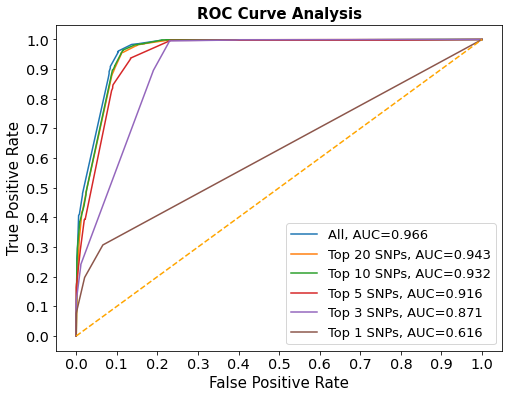

In [129]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(result_table.loc[i]['SNPs'], result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')


plt.show()